#Key Links

*   https://www.kaggle.com/c/inaturalist-2019-fgvc6

*   https://github.com/visipedia/inat_comp (navigate to 2019 - there are multiple years posted here)

*   https://sites.google.com/view/fgvc6/competitions/inaturalist-2019

*   Note this one is for 2017 challenge (not 2019), but it has some helpful info not found yet for 2019: https://sites.google.com/view/fgvc4/competitions/inaturalist

#Summary of Files and Directories in the 'inputs_original' Directory
The following files/directories are taken from the github page linked above for the 2019 challenge. They are also available on the kaggle competition page (first link above).


*   **train_val2019 (directory) -** This contains all the image files from the training and validation sets (in nested subdirectories)
*   **test2019 (directory) -**  This contains all the image files for the test set.
*   **train_val2019.tar.gz** and **test2019.tar.gz** (files) - these have already been unpacked into the above directories (see above), so are not needed.
*   **train2019.json and val2019.json (files) -** These files have the same structure - one is for the training set and the other for the validation set. These .json files are loaded below as dictionaries, and then the notebook converts certain components from these into to data frames (annotations, categories, and images). Other componenents seem less useful and are not loaded (info and licenses).
*   **test2019.json -** this is similar to the train2019.json and val2019.json (see above), except that it lacks certain items (annotations and categories). It only has these items: images, info, and licenses.
*   **categories.json -**  This has similar content to what is in the 'categories' item in the train2019.json and val2019.json. However, this one is unobfuscated (i.e., the names are real, rather than coded values that are unintelligible).
*   **kaggle_sample_submission.csv -** Self-explanatory



# Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MSDS_422_Group/Final_Project

/content/drive/MyDrive/MSDS_422_Group/Final_Project


# Imports

In [66]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import nbconvert
import joblib
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

%matplotlib inline
sns.set()

In [69]:
'''from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from flask import Flask, request, jsonify'''

In [4]:
input_dir = os.path.join(os.getcwd(),'inputs_original')
output_dir = os.path.join(os.getcwd(),'outputs')

#Data Ingestion

First only ingesting the annotations. The collection of images is large and does not make sense to load into memory at one time.

In [5]:
# Opening JSON file that has the annotations for the training data set
f = open(os.path.join(input_dir,"train2019.json"))
# returns JSON object as a dictionary - assign to an object
training_annotations_dict = json.load(f)
# Closing file
f.close()

# Opening JSON file that has the annotations for the validation data set
f = open(os.path.join(input_dir,"val2019.json"))
# returns JSON object as a dictionary - assign to an object
val_annotations_dict = json.load(f)
# Closing file
f.close()

# Opening JSON file that has the unobfuscated category names
f = open(os.path.join(input_dir,"categories.json"))
# returns JSON object as a dictionary - assign to an object
clear_categories = json.load(f)
# Closing file
f.close()

# Opening JSON file that has the test info
f = open(os.path.join(input_dir,"test2019.json"))
# returns JSON object as a dictionary - assign to an object
test_annotations_dict = json.load(f)
# Closing file
f.close()

#Exploratory Data Analysis

View highest level dictionary keys for training and validation annotation dictionaries.

In [6]:
list(training_annotations_dict.keys())

# list(val_annotations_dict.keys())
# the dictionary of annotations for the validation set has the same structure as the one for the training set so commenting out

['info', 'images', 'licenses', 'annotations', 'categories']

In [7]:
list(test_annotations_dict.keys())

['info', 'images', 'licenses']

First create data frames for 'annotations' and 'categories' within the training annotations dictionary to examine those two.

In [8]:
# create data frame from categories
train_categories = training_annotations_dict['categories']

rows = []
for c in range(0, len(train_categories)):
  rows.append(train_categories[c])

train_categories = pd.DataFrame(rows)

# create data frame from annotations
train_annotations = training_annotations_dict['annotations']

rows = []
for a in range(0, len(train_annotations)):
  rows.append(train_annotations[a])

train_annotations = pd.DataFrame(rows)


In [9]:
train_annotations.head()

,image_id,category_id,id
0,0,400,0
1,1,570,1
2,2,167,2
3,3,254,3
4,4,739,4


It looks like the annotations_df has one row for each image in the training set. image_id is a unique ID number associated with that particular image in the training set, while category_id is the coded value for species for that image (i.e., the target that we are trying to classify based on).

In [10]:
train_annotations.shape

(265213, 3)

Based on the above there should be 265,213 images in the training set.

How many unique labels are there in the target variable ('category_id', corresponding to species)?

In [11]:
len(np.unique(train_annotations['category_id']))

1010

There are 1010 species (categories) in the training set, based on the above summary of the annotations_df.   

1010 is also the number of rows in the categories_df object, based on the below, which makes sense. This dataframe appears to have one row per species, and it includes the higher-order phylogenetic membership categories for that species.    

What is less clear, however, is how to join the categories_df with the annotations_df. There is no obvious join field, as the categories_df does not include a column for "category_id", i.e. species. There is a column for "id," in the categories_df, so perhaps we can just assume that "id" here means "category_id." The other possibility would be for 'id' to map to a particular image, showing a representative image for that species. But that seems much less likely and counterintuitive.

In [12]:
train_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   kingdom  1010 non-null   object
 1   phylum   1010 non-null   object
 2   name     1010 non-null   object
 3   family   1010 non-null   object
 4   genus    1010 non-null   object
 5   order    1010 non-null   object
 6   id       1010 non-null   int64 
 7   class    1010 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.2+ KB


In [13]:
train_categories.head()

,kingdom,phylum,name,family,genus,order,id,class
0,SMHLVG,QVXHMU,UYRGAX,RPVDIT,AIEVWT,GWFTGO,0,KSMQKH
1,SMHLVG,QVXHMU,CXIRQX,RPVDIT,AIEVWT,GWFTGO,1,KSMQKH
2,SMHLVG,QVXHMU,JNFLFY,RPVDIT,AIEVWT,GWFTGO,2,KSMQKH
3,SMHLVG,QVXHMU,XVMTNN,RPVDIT,AIEVWT,GWFTGO,3,KSMQKH
4,SMHLVG,QVXHMU,WEXFQY,RPVDIT,AIEVWT,GWFTGO,4,KSMQKH


The values above (which came from the training annotations .json file) are all coded, so they are not recognizable. However, we also have access to the unobfuscated category names, from a separate .json file that was loaded above. We can create a data frame from that, as well, and view it for comparison.

In [14]:
# create data frame from unobfuscated categories...
# 'clear_categories' was initially defined above from a separate .json file.
# here we redefine it as a data frame
rows = []
for c in range(0, len(clear_categories)):
  rows.append(clear_categories[c])

clear_categories = pd.DataFrame(rows)

In [15]:
clear_categories.head()

,kingdom,phylum,name,family,genus,order,id,class
0,Fungi,Basidiomycota,Amanita vaginata,Amanitaceae,Amanita,Agaricales,0,Agaricomycetes
1,Fungi,Basidiomycota,Amanita flavoconia,Amanitaceae,Amanita,Agaricales,1,Agaricomycetes
2,Fungi,Basidiomycota,Amanita calyptroderma,Amanitaceae,Amanita,Agaricales,2,Agaricomycetes
3,Fungi,Basidiomycota,Amanita jacksonii,Amanitaceae,Amanita,Agaricales,3,Agaricomycetes
4,Fungi,Basidiomycota,Amanita phalloides,Amanitaceae,Amanita,Agaricales,4,Agaricomycetes


##Assessing Class Imbalance/Balance
Imbalance could result in poor performance in a neural network for the class(es) with low representation, which will also degrade overall performance. Source: https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a

In [16]:
# create a function to summarize distribution by species or some other grouping

# helper function to make pivot table
def make_summary(df, grouping):
    # create a pivot table to summarize the number of images in the training dataset for each group
    count_by_group = pd.pivot_table(df, index = grouping, aggfunc = 'count')
    count_by_group = count_by_group[['image_id']].reset_index().rename(columns = {'image_id': 'count'})
    return count_by_group

# main function
def view_by_group(df, grouping):
  # call the helper function to make summary for plotting
  count_by_group = make_summary(df, grouping)

  # plot a histogram to see how balanced the representation is across the grouping
  count_by_group['count'].plot(kind='hist', bins=20, title='Histogram of Number of Images per ' + grouping)
  plt.xlabel('Number of Images')
  plt.ylabel('Count of ' + grouping)
  plt.gca().spines[['top', 'right',]].set_visible(False)

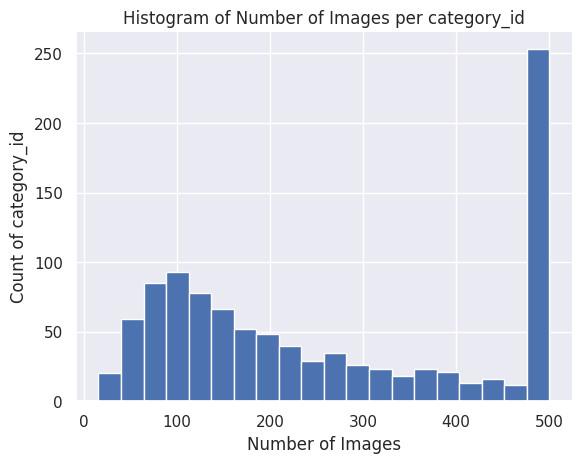

In [17]:
view_by_group(train_annotations, 'category_id')

About 250 species have approximately 500 images each. The remaining species have fewer images, so performance will be worse on those, and especially for the species with very scant representation. We may want to try some data augmentation methods to increase our training set for those species, such as creating image copies that are resized, rotated, etc.

Join the clear_categories data frame to the annotations data frame to create similar summaries of the distribution by higher-level phylogenetic categories (e.g. genus, family, order, class, etc.)

In [18]:
train_annotations = train_annotations.merge(clear_categories, left_on='category_id', right_on='id', indicator=True)

In [19]:
train_annotations.head()

,image_id,category_id,id_x,kingdom,phylum,name,family,genus,order,id_y,class,_merge
0,0,400,0,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,400,Magnoliopsida,both
1,664,400,664,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,400,Magnoliopsida,both
2,1451,400,1451,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,400,Magnoliopsida,both
3,1939,400,1939,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,400,Magnoliopsida,both
4,2269,400,2269,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,400,Magnoliopsida,both


Check whether all the merged items had a match in both frames

In [20]:
train_annotations['_merge'].value_counts()

_merge
both          265213
left_only          0
right_only         0
Name: count, dtype: int64

Yes, looks good.

In [21]:
train_annotations = train_annotations.drop(['_merge', 'id_x','id_y'], axis=1)

Now that the join was successful we can view summaries of the distribution of number of images for other higher-level groupings

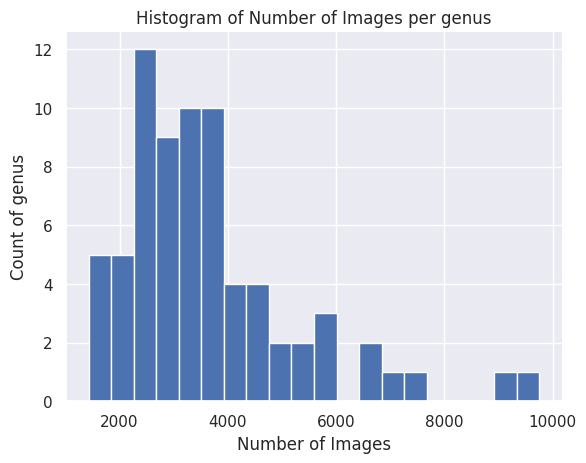

In [23]:
view_by_group(train_annotations, 'genus')

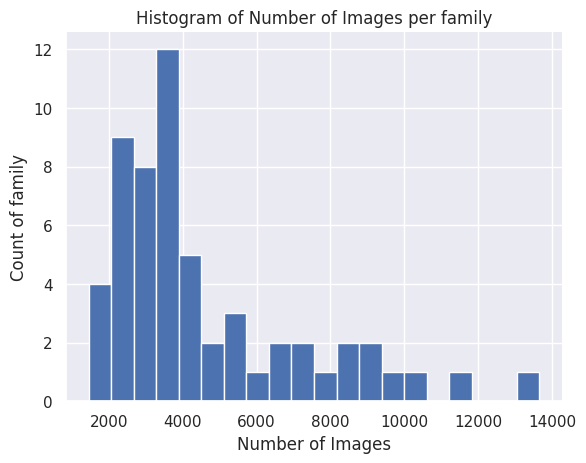

In [24]:
view_by_group(train_annotations, 'family')

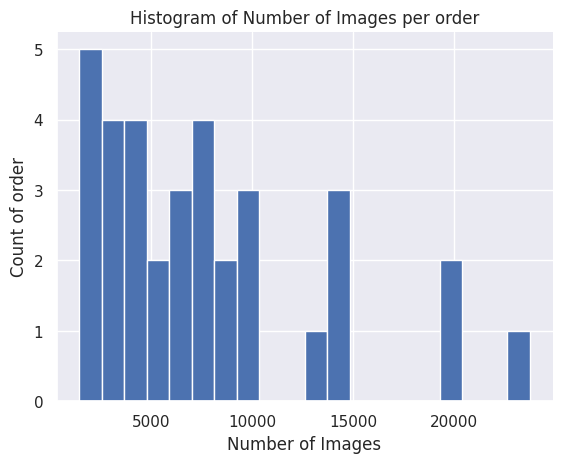

In [25]:
view_by_group(train_annotations, 'order')

There are only 9 different classes so we can represent this as a bar chart instead of a histogram.

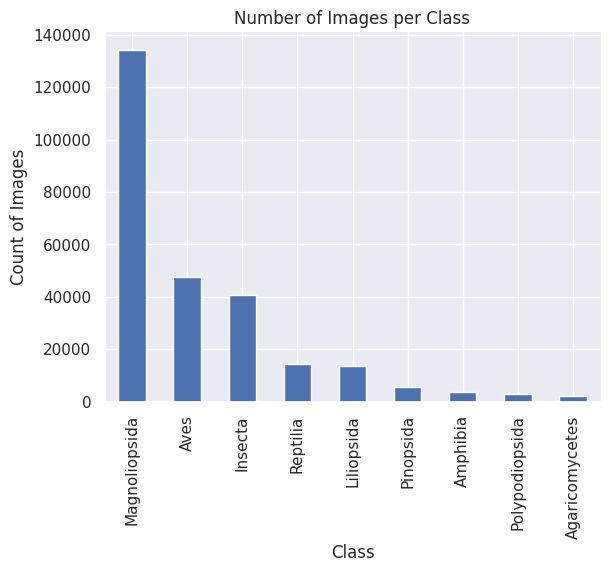

In [26]:
train_annotations['class'].value_counts().plot(kind='bar', title='Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count of Images')
plt.gca().spines[['top', 'right',]].set_visible(False)

Magnoliopsida is the largest class by far. This is a class of flowering plants.

##Plotting Image Size
Image size is also important - higher-resolution photos generally result in better model performance. Source: https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a  


Fortunately the nested dictionary also included a component called images, with data on the dimensions of each image, so we can use that here.

In [27]:
# create data frame from images object in training annotations dictionary

# first pull it in its original form as a list of dictionaries
train_images = training_annotations_dict['images']

# then convert it to a data frame
rows = []
for i in range(0, len(train_images)):
  rows.append(train_images[i])

train_images = pd.DataFrame(rows)

In [28]:
train_images.head()

,license,file_name,rights_holder,height,width,id
0,3,train_val2019/Plants/400/d1322d13ccd856eb4236c...,sydneyspicer,800,600,0
1,3,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,ecoexplore_wnc,533,800,1
2,3,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,genevievec,600,800,2
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,Donna Pomeroy,533,800,3
4,3,train_val2019/Plants/739/ffa06f951e99de9d220ae...,plantcollector,600,800,4


In [29]:
train_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265213 entries, 0 to 265212
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   license        265213 non-null  int64 
 1   file_name      265213 non-null  object
 2   rights_holder  265213 non-null  object
 3   height         265213 non-null  int64 
 4   width          265213 non-null  int64 
 5   id             265213 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 12.1+ MB


Add a new column to calculate the overall size (pixels) based on multiplying height times width of each image.

In [30]:
train_images['pixels'] = train_images['height'] * train_images['width']

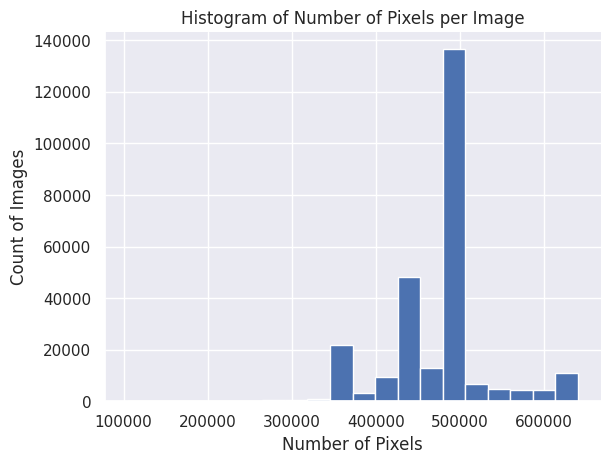

In [31]:
# plot a histogram to see the distribution of sizes across all images
train_images['pixels'].plot(kind='hist', bins=20, title='Histogram of Number of Pixels per Image')
plt.xlabel('Number of Pixels')
plt.ylabel('Count of Images')
plt.gca().spines[['top', 'right',]].set_visible(False)

Based on the above, it doesn't seem like image quality is going to be an issue, but we can try inspecting some of the smallest images below.

##Display a few sample images

In [36]:
# define a function to display an image in the notebook
# source for the below code is: https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
def show_image_sample(pic_directory):
  '''display 4x4 images'''
  fig = plt.gcf()
  fig.set_size_inches(ncols * 4, nrows * 4)
  for i, img_path in enumerate(pic_directory):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.show()

# define another function to display a single image, based on filename
def show_image(filename):
  img_path = os.path.join(input_dir, filename)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.show()

Look at smallest image

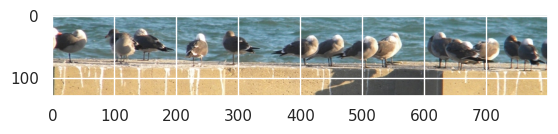

In [37]:
smallest_fn = train_images.loc[train_images['pixels'] == train_images.pixels.min(), 'file_name']

show_image(smallest_fn.values[0])

Other images

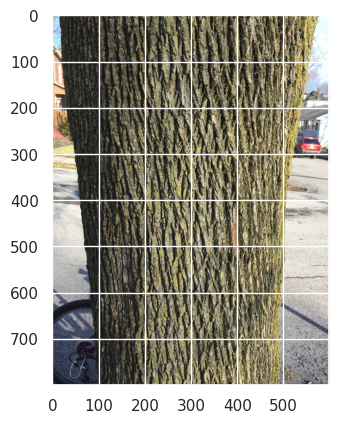

In [38]:
show_image(train_images['file_name'][0])

The above is going to be very difficult to classify at a species level (even for a human subject matter expert it may not be possible).

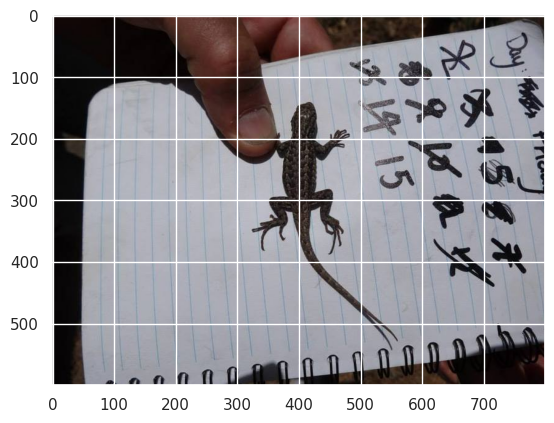

In [46]:
show_image(train_images['file_name'][2])

The above image and many others have a great deal of extraneous content that could confuse a model. We may want to investigate whether there are pre-processing approaches that we could apply to automate the cropping of photos to the likely area of interest, or set one or more bounding box(es).

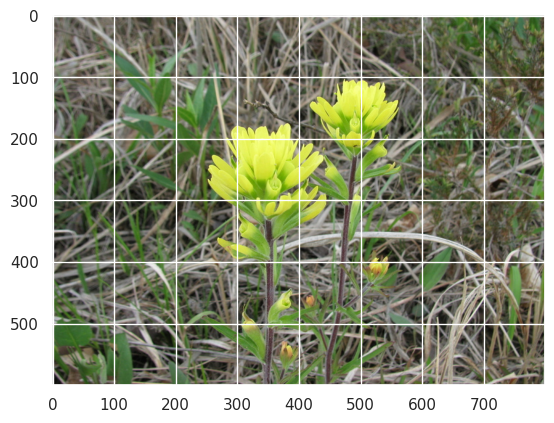

In [47]:
show_image(train_images['file_name'][4])

Let's also check that our assumptions were correct in terms of the varying meaning of the 'id' feature in different objects (sometimes it refers to image id, sometimes category/species id, and sometimes it means neither). To check, take the train_annotations data frame (to which we previously joined the higher phylogenetic groupings based on assumptions) and then join train_images data frame to it (again, with assumptions on the meaning of 'id' field in respective objects). Everything should line up and make sense in the resulting data frame if the assumptions were correct.

In [39]:
train_annotations = train_annotations.merge(train_images, left_on='image_id', right_on='id', indicator=True)
train_annotations.head()

,image_id,category_id,kingdom,phylum,name,family,genus,order,class,license,file_name,rights_holder,height,width,id,pixels,_merge
0,0,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,3,train_val2019/Plants/400/d1322d13ccd856eb4236c...,sydneyspicer,800,600,0,480000,both
1,664,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,3,train_val2019/Plants/400/9e817b65a00b9b4b5bd4c...,Sara Rall,532,800,664,425600,both
2,1451,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,3,train_val2019/Plants/400/57e3a4e1225a824c3b611...,pirilloalberto,450,800,1451,360000,both
3,1939,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,3,train_val2019/Plants/400/bfe3be6cf71cf36ae38ea...,madisonboblett,800,600,1939,480000,both
4,2269,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,3,train_val2019/Plants/400/b5c93a1adede333a7d799...,Mark Warman,800,600,2269,480000,both


So far, so good. "id" from the train_images data frame matches "image_id" from the train_annotations data frame. And the directory structure in the "file_name" field from the train_images data frame seems consistent with the "kingdom" field from the clear_categories data frame. Filter on a more rare class for a more secure check.

In [40]:
amphibians = train_annotations[train_annotations['class'] == 'Amphibia']
amphibians.head()

,image_id,category_id,kingdom,phylum,name,family,genus,order,class,license,file_name,rights_holder,height,width,id,pixels,_merge
14205,43,158,Animalia,Chordata,Lithobates pipiens,Ranidae,Lithobates,Anura,Amphibia,3,train_val2019/Amphibians/158/740697f9c928eaa04...,Sarah Bonnett,800,600,43,480000,both
14206,482,158,Animalia,Chordata,Lithobates pipiens,Ranidae,Lithobates,Anura,Amphibia,3,train_val2019/Amphibians/158/cbf798205e9888a90...,Holly Jasmine Long,800,600,482,480000,both
14207,1126,158,Animalia,Chordata,Lithobates pipiens,Ranidae,Lithobates,Anura,Amphibia,1,train_val2019/Amphibians/158/cdd51e0d791e30dea...,josh_vandermeulen,473,800,1126,378400,both
14208,1504,158,Animalia,Chordata,Lithobates pipiens,Ranidae,Lithobates,Anura,Amphibia,3,train_val2019/Amphibians/158/9bdace1fdcb6b8919...,jwboreal,600,800,1504,480000,both
14209,1912,158,Animalia,Chordata,Lithobates pipiens,Ranidae,Lithobates,Anura,Amphibia,3,train_val2019/Amphibians/158/0df25448abdb1b6a3...,gshugart,800,600,1912,480000,both


Yes, all of the above makes sense. The assumptions appear to have been correct.   

In [41]:
del amphibians

In [42]:
train_annotations['_merge'].value_counts()

_merge
both          265213
left_only          0
right_only         0
Name: count, dtype: int64

Also, based on the above, all of the items had a match in both data frames that were merged.

Drop redundant or useless features.

In [43]:
train_annotations = train_annotations.drop(['license', 'rights_holder', 'id', '_merge','height','width'], axis=1)

Check for null values

In [44]:
na_counts = train_annotations.isna().sum()
na_percentage = (train_annotations.isna().sum() / len(train_annotations)) * 100

na_summary = pd.DataFrame({'NA_Count': na_counts, 'Percentage': na_percentage})
print(na_summary)

             NA_Count  Percentage
image_id            0         0.0
category_id         0         0.0
kingdom             0         0.0
phylum              0         0.0
name                0         0.0
family              0         0.0
genus               0         0.0
order               0         0.0
class               0         0.0
file_name           0         0.0
pixels              0         0.0


Convert the ID's to strings since they are truly nominal rather than numeric.

In [45]:
train_annotations['category_id'] = train_annotations['category_id'].astype(str)
train_annotations['image_id'] = train_annotations['image_id'].astype(str)

In [46]:
train_annotations.head()

,image_id,category_id,kingdom,phylum,name,family,genus,order,class,file_name,pixels
0,0,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,train_val2019/Plants/400/d1322d13ccd856eb4236c...,480000
1,664,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,train_val2019/Plants/400/9e817b65a00b9b4b5bd4c...,425600
2,1451,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,train_val2019/Plants/400/57e3a4e1225a824c3b611...,360000
3,1939,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,train_val2019/Plants/400/bfe3be6cf71cf36ae38ea...,480000
4,2269,400,Plantae,Tracheophyta,Acer platanoides,Sapindaceae,Acer,Sapindales,Magnoliopsida,train_val2019/Plants/400/b5c93a1adede333a7d799...,480000


Now let's create a new streamlined data frame that only includes the essential info for model training

In [47]:
train_labels_simple = train_annotations[['image_id', 'category_id', 'file_name']]

Create a similar data frame for the validation set. This time we can do it more concisely now that we know what the different data elements contain and what we need.

In [ ]:
# pull annotations
val_df = pd.DataFrame(val_annotations_dict['annotations'])[['image_id','category_id']]

# pull image info (filenames)
val_img = pd.DataFrame(val_annotations_dict['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})

# merge the two above into one data frame
val_df = val_df.merge(val_img, on='image_id', indicator = True)

# convert id columns to string since they are nominal
val_df['category_id'] = val_df['category_id'].astype(str)
val_df['image_id'] = val_df['image_id'].astype(str)

# check how the merge went
val_df['_merge'].value_counts()

In [ ]:
# drop merge indicator column as it is no longer needed
val_df = val_df.drop(['_merge'], axis=1)

# view result
val_df.head()

##Data Pre-Processing and Feature Engineering

As discussed above, we can augment our training data by generating mutated copies of images (e.g. randomly resized, rescaled, rotated, flipped, etc.) and adding them to the pool of images to train on. This may be especially beneficial to improve the classification for species that are underrepresented in the original data, but we can also just apply it to the whole dataset. See page 315 (Chapter 11) of Hands-On Learning with Scikit-Learn & TensorFlow by Aurelien Geron. See also: https://www.geeksforgeeks.org/python-data-augmentation/. See also https://www.tensorflow.org/api_docs/python/tf/image.

Source for the below code: https://www.kaggle.com/code/hsinwenchang/keras-mobilenet-data-augmentation-visualize

In [62]:
nb_classes = 1010
batch_size = 128
img_size = 128
nb_epochs = 10

In [68]:
%%time
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_labels_simple,
    directory=input_dir,
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="sparse",
    target_size=(img_size,img_size))

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 41635 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 223578 validated image filenames belonging to 899 classes.
CPU times: user 13.8 s, sys: 16.9 s, total: 30.7 s
Wall time: 20min 44s


In [70]:
joblib.dump(train_generator, 'train_generator.pkl')

TypeError: cannot pickle '_thread.lock' object

Display some examples of augmented data based on applying the train_generator to a particular image

source for the below function: https://www.kaggle.com/code/hsinwenchang/keras-mobilenet-data-augmentation-visualize   
but ultimately from: udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb#scrollTo=jqb9OGoVKIOi

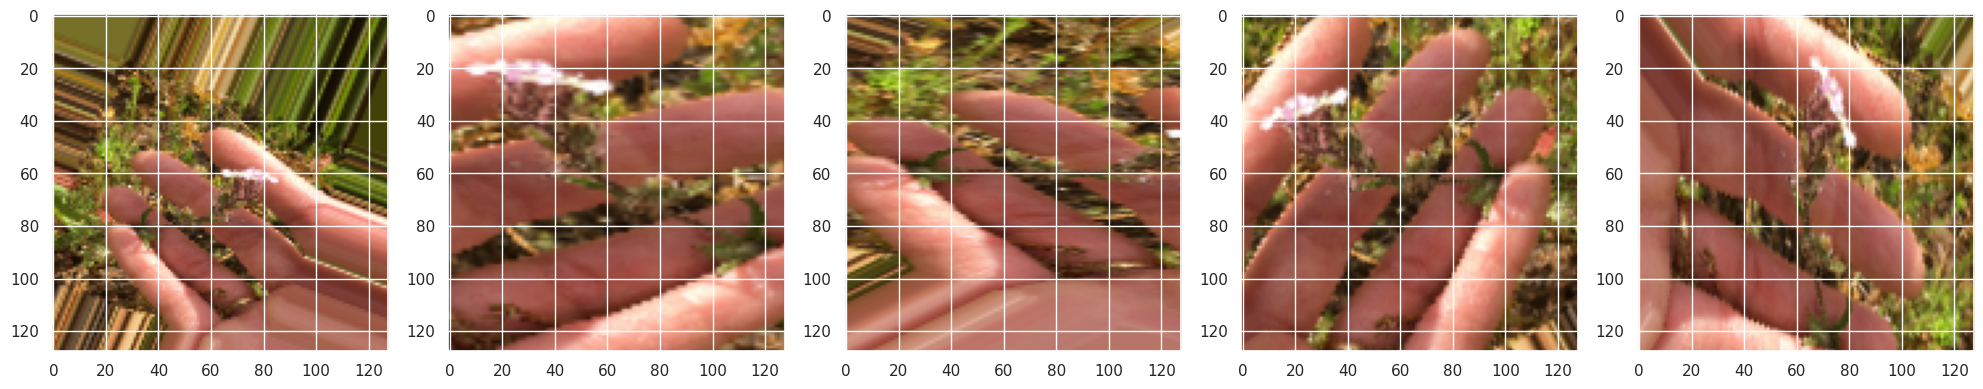

In [71]:
# This function will plot images in a grid so we can view an example of the augmentation results
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

We can also try adding brightness_range = (0.5,1.5) as an additional argument in the ImageDataGenerator function above. I saw that on https://www.geeksforgeeks.org/python-data-augmentation/

# Model Building

Hey Kevin - this page toward the bottom explains the methods and model architectures used by competing teams in the 2017 challenge (different than the 2019 challenge that we are working with, but nevertheless may be helpful for reference): https://sites.google.com/view/fgvc4/competitions/inaturalist  Pre-trained models like ResNet50 are allowed.

Also, you may find it interesting to refer to the code that others submitted on Kaggle showing how they addressed this Kaggle challenge, building models, etc. As long as we cite our sources we can freely adopt code from others' solutions. check out: https://www.kaggle.com/competitions/inaturalist-2019-fgvc6/code

Also, if you go to the runtime menu at the top and choose "change runtime type" you can switch to a GPU, in case that is helpful. Not sure if that would be needed for this.  

Finally, if we end up deciding to use the data augmentation methods that I piloted above, one decision is whether we want to:


1.   Perform that generation of new images on the fly, while training the model
OR
2.   Generate the augmented data images beforehand and save them in the drive.

My understanding is that there pros and cons to both approaches. From a compute perspective, option 1 is better for memory management, if we are worried about running out of memory, however it takes longer to train the model. Option 2, conversely, uses more memory but model training is faster. There are other pros and cons too... maybe take a look and see what you think.

I created a train_generator object that generates new images based on mutating the original ones (see above, and I tested it on one particular image). It works - however, I ran into an error when I tried to pickle the train_generator. Not sure why, but I can investigate and hopefully fix it so we won't have to wait to recreate the object every session. It takes about 20 minutes. Also, feel free to suggest additional changes for the augmentation.

Thanks,  

Andrew

# Evaluation

# Generate .html and then convert to PDF to include as appendix of report

In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/MSDS_422_Group/Final_Project/iNaturalist.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/MSDS_422_Group/Week_3/Assignment_3.ipynb to html
[NbConvertApp] Writing 1282796 bytes to /content/drive/MyDrive/MSDS_422_Group/Week_3/Assignment_3.html
